# HSOA (Harmony Search Optimization Algorithm) para TSP

Este notebook implementa el algoritmo HSOA adaptado al Problema del Viajante (TSP - Traveling Salesman Problem).

## Estructura del algoritmo:
1. **Inicialización**: Generar población de rutas aleatorias
2. **Búsqueda iterativa**: Exploración y explotación mediante operadores de movimiento
3. **Convergencia**: Movimiento hacia la mejor solución encontrada

## Importar librerías necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
import time

## Hyperparámetros

In [ ]:
PROB_EXPLORACION = 0.1
PROB_EXPLOTACION = 0.3
MAX_ITERACIONES = 500
SNIFFER_COUNT = 30

## Definición de la matriz de distancias y ciudades

In [ ]:
def crear_matriz_distancias(num_ciudades: int, tipo: str = 'aleatoria') -> np.ndarray:
    """
    Crea una matriz de distancias entre ciudades.
    
    Args:
        num_ciudades: Número de ciudades
        tipo: 'aleatoria' para coordenadas aleatorias, 'simetrica' para matriz simétrica aleatoria
    
    Returns:
        Matriz de distancias (numpy array)
    """
    if tipo == 'aleatoria':
        # Generar coordenadas aleatorias para cada ciudad
        coordenadas = np.random.rand(num_ciudades, 2) * 100
        
        # Calcular matriz de distancias euclidiana
        matriz_distancias = np.zeros((num_ciudades, num_ciudades))
        for i in range(num_ciudades):
            for j in range(num_ciudades):
                if i != j:
                    dist = np.sqrt((coordenadas[i, 0] - coordenadas[j, 0])**2 + 
                                 (coordenadas[i, 1] - coordenadas[j, 1])**2)
                    matriz_distancias[i, j] = dist
        
        return matriz_distancias, coordenadas
    
    elif tipo == 'simetrica':
        # Generar matriz simétrica aleatoria
        matriz_distancias = np.random.rand(num_ciudades, num_ciudades) * 100
        matriz_distancias = (matriz_distancias + matriz_distancias.T) / 2
        np.fill_diagonal(matriz_distancias, 0)
        return matriz_distancias, None

# Ejemplo: Crear problema TSP con 20 ciudades
num_ciudades = 20
matriz_distancias, coordenadas = crear_matriz_distancias(num_ciudades, tipo='aleatoria')

print(f"Problema TSP con {num_ciudades} ciudades")
print(f"Forma de la matriz de distancias: {matriz_distancias.shape}")
print(f"\nPrimeras 5x5 distancias:\n{matriz_distancias[:5, :5]}")

Problema TSP con 20 ciudades
Forma de la matriz de distancias: (20, 20)

Primeras 5x5 distancias:
[[ 0.         50.08000016 22.31370149 34.04577284 80.77351717]
 [50.08000016  0.         68.8003775  16.17902561 70.85664478]
 [22.31370149 68.8003775   0.         53.66813595 80.11247613]
 [34.04577284 16.17902561 53.66813595  0.         72.17802549]
 [80.77351717 70.85664478 80.11247613 72.17802549  0.        ]]


## Funciones auxiliares para el TSP

In [ ]:
def calcular_distancia_ruta(ruta: List[int], matriz_distancias: np.ndarray) -> float:
    """
    Calcula la distancia total de una ruta.
    
    Args:
        ruta: Lista de índices de ciudades en el orden de visita
        matriz_distancias: Matriz de distancias entre ciudades
    
    Returns:
        Distancia total de la ruta
    """
    distancia_total = 0.0
    for i in range(len(ruta) - 1):
        distancia_total += matriz_distancias[ruta[i], ruta[i + 1]]
    # Añadir distancia de regreso a la ciudad inicial
    distancia_total += matriz_distancias[ruta[-1], ruta[0]]
    return distancia_total


def generar_ruta_aleatoria(num_ciudades: int) -> List[int]:
    """
    Genera una ruta aleatoria (permutación de ciudades).
    
    Args:
        num_ciudades: Número total de ciudades
    
    Returns:
        Lista con permutación aleatoria de índices de ciudades
    """
    ruta = list(range(num_ciudades))
    random.shuffle(ruta)
    return ruta


# Probar las funciones
ruta_ejemplo = generar_ruta_aleatoria(num_ciudades)
distancia_ejemplo = calcular_distancia_ruta(ruta_ejemplo, matriz_distancias)

print(f"Ruta ejemplo: {ruta_ejemplo[:10]}... (primeras 10 ciudades)")
print(f"Distancia total: {distancia_ejemplo:.2f}")

Ruta ejemplo: [10, 15, 7, 12, 0, 19, 14, 5, 2, 6]... (primeras 10 ciudades)
Distancia total: 946.61


## Operadores de movimiento para exploración

In [ ]:
def operador_swap(ruta: List[int]) -> List[int]:
    """
    Operador de intercambio (swap): intercambia dos ciudades aleatorias.
    
    Args:
        ruta: Ruta original
    
    Returns:
        Nueva ruta con dos ciudades intercambiadas
    """
    nueva_ruta = ruta.copy()
    i, j = random.sample(range(len(ruta)), 2)
    nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
    return nueva_ruta


def operador_inversion(ruta: List[int]) -> List[int]:
    """
    Operador de inversión: invierte un segmento aleatorio de la ruta.
    
    Args:
        ruta: Ruta original
    
    Returns:
        Nueva ruta con un segmento invertido
    """
    nueva_ruta = ruta.copy()
    i, j = sorted(random.sample(range(len(ruta)), 2))
    nueva_ruta[i:j+1] = reversed(nueva_ruta[i:j+1])
    return nueva_ruta


def operador_insercion(ruta: List[int]) -> List[int]:
    """
    Operador de inserción: extrae una ciudad y la inserta en otra posición.
    
    Args:
        ruta: Ruta original
    
    Returns:
        Nueva ruta con una ciudad reubicada
    """
    nueva_ruta = ruta.copy()
    i = random.randint(0, len(ruta) - 1)
    j = random.randint(0, len(ruta) - 1)
    ciudad = nueva_ruta.pop(i)
    nueva_ruta.insert(j, ciudad)
    return nueva_ruta


def aplicar_operador_movimiento(ruta: List[int], tipo: str = 'aleatorio') -> List[int]:
    """
    Aplica un operador de movimiento a la ruta.
    
    Args:
        ruta: Ruta original
        tipo: Tipo de operador ('swap', 'inversion', 'insercion', 'aleatorio')
    
    Returns:
        Nueva ruta modificada
    """
    if tipo == 'aleatorio':
        tipo = random.choice(['swap', 'inversion', 'insercion'])
    
    if tipo == 'swap':
        return operador_swap(ruta)
    elif tipo == 'inversion':
        return operador_inversion(ruta)
    elif tipo == 'insercion':
        return operador_insercion(ruta)
    else:
        raise ValueError(f"Tipo de operador desconocido: {tipo}")


# Probar operadores
print("Ruta original:", ruta_ejemplo[:10], "...")
print("Después de swap:", operador_swap(ruta_ejemplo)[:10], "...")
print("Después de inversión:", operador_inversion(ruta_ejemplo)[:10], "...")
print("Después de inserción:", operador_insercion(ruta_ejemplo)[:10], "...")

Ruta original: [10, 15, 7, 12, 0, 19, 14, 5, 2, 6] ...
Después de swap: [10, 15, 7, 12, 8, 19, 14, 5, 2, 6] ...
Después de inversión: [10, 13, 1, 18, 3, 17, 11, 9, 8, 6] ...
Después de inserción: [10, 15, 12, 0, 19, 14, 5, 2, 6, 8] ...


## Operador de combinación para explotación

In [ ]:
def combinar_rutas_orden(ruta: List[int], mejor_ruta: List[int], probabilidad: float = 0.5) -> List[int]:
    """
    Combina parcialmente una ruta con la mejor ruta preservando el orden.
    Copia segmentos de la mejor ruta manteniendo una permutación válida.
    
    Args:
        ruta: Ruta a modificar
        mejor_ruta: Mejor ruta encontrada hasta el momento
        probabilidad: Probabilidad de copiar cada ciudad de la mejor ruta
    
    Returns:
        Nueva ruta combinada
    """
    n = len(ruta)
    # Determinar longitud del segmento a copiar
    longitud_segmento = random.randint(n // 4, n // 2)
    inicio = random.randint(0, n - longitud_segmento)
    
    # Copiar segmento de la mejor ruta
    segmento = mejor_ruta[inicio:inicio + longitud_segmento]
    
    # Crear nueva ruta: colocar el segmento en la misma posición
    nueva_ruta = [None] * n
    nueva_ruta[inicio:inicio + longitud_segmento] = segmento
    
    # Completar con las ciudades restantes de la ruta original en orden
    ciudades_usadas = set(segmento)
    idx = 0
    for i in range(n):
        if nueva_ruta[i] is None:
            # Buscar siguiente ciudad no usada de la ruta original
            while ruta[idx] in ciudades_usadas:
                idx += 1
            nueva_ruta[i] = ruta[idx]
            ciudades_usadas.add(ruta[idx])
            idx += 1
    
    return nueva_ruta


def combinar_rutas_posicion(ruta: List[int], mejor_ruta: List[int], probabilidad: float = PROB_EXPLOTACION) -> List[int]:
    """
    Combina ruta con la mejor ruta copiando ciudades en posiciones específicas.
    
    Args:
        ruta: Ruta a modificar
        mejor_ruta: Mejor ruta encontrada
        probabilidad: Probabilidad de copiar cada posición
    
    Returns:
        Nueva ruta combinada
    """
    nueva_ruta = ruta.copy()
    
    # Seleccionar algunas posiciones para copiar de la mejor ruta
    for i in range(len(ruta)):
        if random.random() < probabilidad:
            ciudad_mejor = mejor_ruta[i]
            # Encontrar dónde está esa ciudad en la nueva ruta
            j = nueva_ruta.index(ciudad_mejor)
            # Intercambiar
            nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
    
    return nueva_ruta


# Probar combinación
ruta_test = generar_ruta_aleatoria(10)
mejor_ruta_test = generar_ruta_aleatoria(10)

print("Ruta original:", ruta_test)
print("Mejor ruta:", mejor_ruta_test)
print("Combinación por orden:", combinar_rutas_orden(ruta_test, mejor_ruta_test))
print("Combinación por posición:", combinar_rutas_posicion(ruta_test, mejor_ruta_test))

Ruta original: [0, 2, 3, 1, 5, 4, 6, 9, 8, 7]
Mejor ruta: [2, 5, 1, 3, 0, 7, 4, 9, 8, 6]
Combinación por orden: [2, 3, 1, 5, 0, 7, 4, 6, 9, 8]
Combinación por posición: [0, 2, 1, 3, 5, 4, 6, 9, 8, 7]


## Implementación del algoritmo HSOA para TSP

In [ ]:
class HSOA_TSP:
    """
    Harmony Search Optimization Algorithm adaptado al TSP.
    """
    
    def __init__(self, 
                 matriz_distancias: np.ndarray,
                 sniffer_count: int = SNIFFER_COUNT,
                 max_iteraciones: int = MAX_ITERACIONES,
                 prob_exploracion: float = PROB_EXPLORACION,
                 prob_explotacion: float = PROB_EXPLOTACION,
                 verbose: bool = True):
        """
        Inicializa el algoritmo HSOA para TSP.
        
        Args:
            matriz_distancias: Matriz de distancias entre ciudades
            sniffer_count: Número de rutas en la población
            max_iteraciones: Número máximo de iteraciones
            prob_exploracion: Probabilidad de aceptar solución peor (exploración aleatoria)
            prob_explotacion: Probabilidad de combinar con mejor ruta
            verbose: Si True, imprime información durante la ejecución
        """
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = len(matriz_distancias)
        self.sniffer_count = sniffer_count
        self.max_iteraciones = max_iteraciones
        self.prob_exploracion = prob_exploracion
        self.prob_explotacion = prob_explotacion
        self.verbose = verbose
        
        # Población de rutas
        self.poblacion = []
        self.distancias = []
        
        # Mejor solución encontrada
        self.mejor_ruta = None
        self.mejor_distancia = float('inf')
        
        # Historial de convergencia
        self.historial_mejor = []
        self.historial_promedio = []
    
    def inicializar_poblacion(self):
        """
        Paso 1: Inicialización - Genera población inicial de rutas aleatorias.
        """
        if self.verbose:
            print("=" * 60)
            print("PASO 1: INICIALIZACIÓN")
            print("=" * 60)
        
        self.poblacion = []
        self.distancias = []
        
        for k in range(self.sniffer_count):
            # Generar ruta aleatoria
            ruta = generar_ruta_aleatoria(self.num_ciudades)
            distancia = calcular_distancia_ruta(ruta, self.matriz_distancias)
            
            self.poblacion.append(ruta)
            self.distancias.append(distancia)
            
            # Actualizar mejor ruta
            if distancia < self.mejor_distancia:
                self.mejor_distancia = distancia
                self.mejor_ruta = ruta.copy()
        
        if self.verbose:
            print(f"Población inicial: {self.sniffer_count} rutas")
            print(f"Mejor distancia inicial: {self.mejor_distancia:.2f}")
            print(f"Distancia promedio: {np.mean(self.distancias):.2f}")
            print(f"Distancia peor: {max(self.distancias):.2f}")
    
    def busqueda_iterativa(self):
        """
        Paso 2: Búsqueda iterativa - Exploración y explotación.
        """
        if self.verbose:
            print("\n" + "=" * 60)
            print("PASO 2: BÚSQUEDA ITERATIVA")
            print("=" * 60)
        
        for iteracion in range(self.max_iteraciones):
            # Fase de exploración: aplicar operadores de movimiento
            for i in range(self.sniffer_count):
                ruta_actual = self.poblacion[i]
                distancia_actual = self.distancias[i]
                
                # Generar nueva ruta con operador de movimiento
                nueva_ruta = aplicar_operador_movimiento(ruta_actual, tipo='aleatorio')
                nueva_distancia = calcular_distancia_ruta(nueva_ruta, self.matriz_distancias)
                
                # Criterio de aceptación
                if nueva_distancia < distancia_actual:
                    # Aceptar mejora
                    self.poblacion[i] = nueva_ruta
                    self.distancias[i] = nueva_distancia
                elif random.random() < self.prob_exploracion:
                    # Aceptar con pequeña probabilidad (exploración)
                    self.poblacion[i] = nueva_ruta
                    self.distancias[i] = nueva_distancia
            
            # Actualizar mejor ruta global
            idx_mejor = np.argmin(self.distancias)
            if self.distancias[idx_mejor] < self.mejor_distancia:
                self.mejor_distancia = self.distancias[idx_mejor]
                self.mejor_ruta = self.poblacion[idx_mejor].copy()
            
            # Fase de explotación: combinar con mejor ruta
            for i in range(self.sniffer_count):
                if random.random() < self.prob_explotacion:
                    # Combinar con la mejor ruta
                    ruta_combinada = combinar_rutas_orden(
                        self.poblacion[i], 
                        self.mejor_ruta
                    )
                    distancia_combinada = calcular_distancia_ruta(
                        ruta_combinada, 
                        self.matriz_distancias
                    )
                    
                    # Aceptar si es mejor
                    if distancia_combinada < self.distancias[i]:
                        self.poblacion[i] = ruta_combinada
                        self.distancias[i] = distancia_combinada
            
            # Guardar historial
            self.historial_mejor.append(self.mejor_distancia)
            self.historial_promedio.append(np.mean(self.distancias))
            
            # Mostrar progreso
            if self.verbose and (iteracion % 100 == 0 or iteracion == self.max_iteraciones - 1):
                print(f"Iteración {iteracion:4d} | "
                      f"Mejor: {self.mejor_distancia:8.2f} | "
                      f"Promedio: {np.mean(self.distancias):8.2f} | "
                      f"Peor: {max(self.distancias):8.2f}")
    
    def optimizar(self) -> Tuple[List[int], float]:
        """
        Ejecuta el algoritmo HSOA completo.
        
        Returns:
            Tupla con (mejor_ruta, mejor_distancia)
        """
        tiempo_inicio = time.time()
        
        # Paso 1: Inicialización
        self.inicializar_poblacion()
        
        # Paso 2: Búsqueda iterativa
        self.busqueda_iterativa()
        
        tiempo_total = time.time() - tiempo_inicio
        
        # Paso 3: Resultado
        if self.verbose:
            print("\n" + "=" * 60)
            print("PASO 3: RESULTADO FINAL")
            print("=" * 60)
            print(f"Mejor ruta encontrada: {self.mejor_ruta}")
            print(f"Distancia total: {self.mejor_distancia:.2f}")
            print(f"Tiempo de ejecución: {tiempo_total:.2f} segundos")
        
        return self.mejor_ruta, self.mejor_distancia
    
    def plot_convergencia(self):
        """
        Grafica la convergencia del algoritmo.
        """
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.historial_mejor, label='Mejor distancia', linewidth=2)
        plt.plot(self.historial_promedio, label='Distancia promedio', alpha=0.7)
        plt.xlabel('Iteración')
        plt.ylabel('Distancia')
        plt.title('Convergencia del HSOA')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        mejora = ((self.historial_mejor[0] - np.array(self.historial_mejor)) / 
                  self.historial_mejor[0] * 100)
        plt.plot(mejora, color='green', linewidth=2)
        plt.xlabel('Iteración')
        plt.ylabel('Mejora (%)')
        plt.title('Porcentaje de mejora respecto a solución inicial')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


print("Clase HSOA_TSP definida correctamente ✓")

Clase HSOA_TSP definida correctamente ✓


## Función de visualización de la ruta

In [ ]:
def visualizar_ruta(ruta: List[int], coordenadas: np.ndarray, distancia: float, titulo: str = "Ruta TSP"):
    """
    Visualiza una ruta del TSP en un gráfico 2D.
    
    Args:
        ruta: Lista de índices de ciudades en orden de visita
        coordenadas: Array con coordenadas (x, y) de cada ciudad
        distancia: Distancia total de la ruta
        titulo: Título del gráfico
    """
    if coordenadas is None:
        print("No hay coordenadas disponibles para visualizar.")
        return
    
    plt.figure(figsize=(10, 8))
    
    # Dibujar las ciudades
    plt.scatter(coordenadas[:, 0], coordenadas[:, 1], 
               c='red', s=200, zorder=3, alpha=0.7, edgecolors='black')
    
    # Etiquetar las ciudades
    for i, (x, y) in enumerate(coordenadas):
        plt.annotate(str(i), (x, y), fontsize=9, ha='center', va='center', color='white', weight='bold')
    
    # Dibujar la ruta
    for i in range(len(ruta)):
        ciudad_actual = ruta[i]
        ciudad_siguiente = ruta[(i + 1) % len(ruta)]
        
        x1, y1 = coordenadas[ciudad_actual]
        x2, y2 = coordenadas[ciudad_siguiente]
        
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=1.5, alpha=0.6, zorder=1)
        
        # Añadir flecha para mostrar dirección
        if i < len(ruta) - 1 or i == len(ruta) - 1:
            dx, dy = x2 - x1, y2 - y1
            plt.arrow(x1 + dx*0.3, y1 + dy*0.3, dx*0.15, dy*0.15,
                     head_width=2, head_length=1.5, fc='blue', ec='blue', alpha=0.5, zorder=2)
    
    plt.title(f'{titulo}\nDistancia total: {distancia:.2f}', fontsize=14, weight='bold')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


print("Función de visualización definida correctamente ✓")

Función de visualización definida correctamente ✓


## Ejemplo de ejecución: Problema TSP con 20 ciudades

In [ ]:
# Configuración de semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Crear problema TSP
num_ciudades = 20
matriz_distancias, coordenadas = crear_matriz_distancias(num_ciudades, tipo='aleatoria')

# Configurar y ejecutar HSOA
hsoa = HSOA_TSP(
    matriz_distancias=matriz_distancias,
    sniffer_count=SNIFFER_COUNT,           # Tamaño de población
    max_iteraciones=MAX_ITERACIONES,        # Número de iteraciones
    prob_exploracion=PROB_EXPLORACION,       # Probabilidad de aceptar solución peor
    prob_explotacion=PROB_EXPLOTACION,       # Probabilidad de combinar con mejor ruta
    verbose=True
)

# Ejecutar optimización
mejor_ruta, mejor_distancia = hsoa.optimizar()

PASO 1: INICIALIZACIÓN
Población inicial: 30 rutas
Mejor distancia inicial: 898.07
Distancia promedio: 1093.62
Distancia peor: 1279.07

PASO 2: BÚSQUEDA ITERATIVA
Iteración    0 | Mejor:   877.94 | Promedio:  1059.55 | Peor:  1187.19
Iteración  100 | Mejor:   389.98 | Promedio:   585.24 | Peor:   813.51
Iteración  100 | Mejor:   389.98 | Promedio:   585.24 | Peor:   813.51
Iteración  200 | Mejor:   386.63 | Promedio:   480.33 | Peor:   708.39
Iteración  300 | Mejor:   386.63 | Promedio:   485.21 | Peor:   847.60
Iteración  400 | Mejor:   386.63 | Promedio:   460.00 | Peor:   908.66
Iteración  499 | Mejor:   386.63 | Promedio:   461.34 | Peor:   629.64

PASO 3: RESULTADO FINAL
Mejor ruta encontrada: [16, 5, 3, 13, 8, 11, 9, 7, 2, 18, 14, 10, 15, 6, 19, 1, 17, 4, 12, 0]
Distancia total: 386.63
Tiempo de ejecución: 0.35 segundos
Iteración  200 | Mejor:   386.63 | Promedio:   480.33 | Peor:   708.39
Iteración  300 | Mejor:   386.63 | Promedio:   485.21 | Peor:   847.60
Iteración  400 | Mej

##### Visualización de resultados

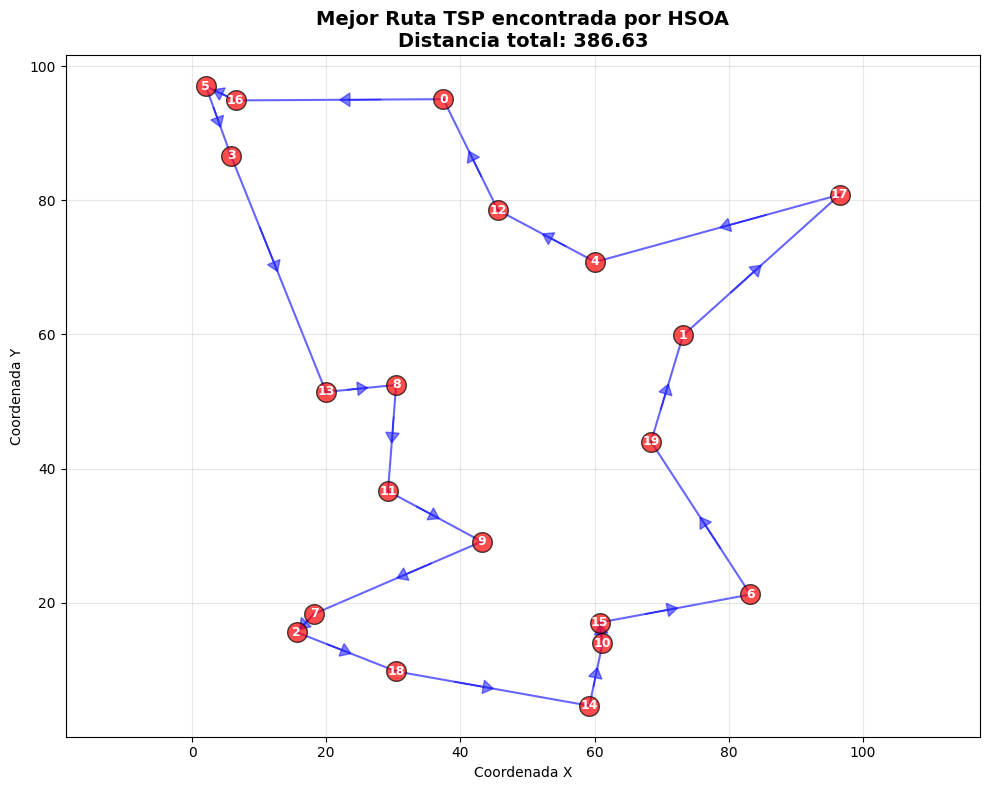

In [ ]:
# Visualizar la mejor ruta encontrada
visualizar_ruta(mejor_ruta, coordenadas, mejor_distancia, 
                titulo="Mejor Ruta TSP encontrada por HSOA")

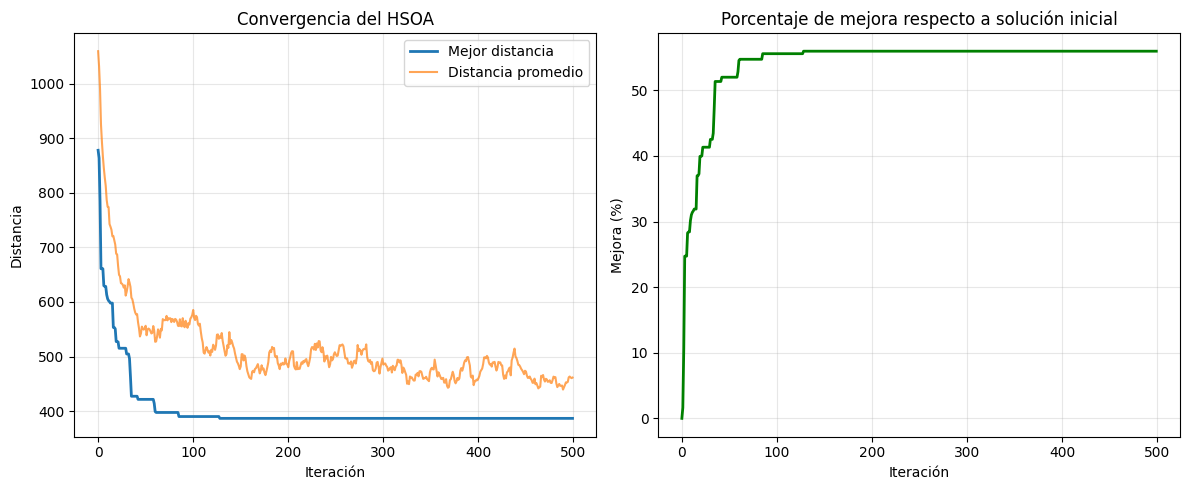

In [ ]:
# Visualizar convergencia del algoritmo
hsoa.plot_convergencia()